# Section 1: Business Understanding

The aim of this project is to provide data analysis on Boston crimes dataset available on www.kaggle.com. This notebook will provide analysis and visualisation to answear the following questions: 

## Question 1. What are the most common crimes commited in Boston?

## Question 2. What is the most dangerous district in Boston?

## Question 3. When most crimes are committed? (Which month, day of week, hour)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from statsmodels.stats.weightstats import ztest
import seaborn as sns

In [2]:
sns.set()

# Section 2: Data Understanding

## Gather

Let us start with uploading the data

In [3]:
data = pd.read_csv('crime.csv', encoding = 'latin')
data.shape

(319073, 17)

In [4]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


## Data preparation


Checking null values in the dataset

In [5]:
data.isna().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64

We can see that there are some missing values in some columns. We should fill NA's in SHOOTING column becouse there is NA value when there was no shooting. 

Regarding other columns we will neither delete missing observations nor fill them with any value. When we will analyse or visualize any specific column then we will decide whether delete or not missing values.

The reason for not deleting missing values is that we might loose some important information when deleting NA's e.g. when deleting row with missing Latitude we could potentially delete an observation with District value.

Let's fill NA's in SHOOTING.

In [6]:
data['SHOOTING'] = [1 if i=='Y' else 0 for i in data['SHOOTING']]

Let's take a look at what districts are used in the dataset?

In [7]:
data.DISTRICT.sort_values().unique()

array(['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13',
       'E18', 'E5', nan], dtype=object)

DISTRICT column is filled with a code for this specific distirict. Let's replace those codes with actual district name.

In [8]:
# replace the codes of districts with actual district names

data['district_name'] = data.DISTRICT

data.district_name.replace({'A1' : 'Downtown',
'A1': 'Downtown',
'A15': 'Charlestown',
'A7': 'East Boston',
'B2': 'Roxbury',
'B3': 'Mattapan',
'C6': 'South Boston',
'C11': 'Dorchester',
'D4': 'South End',
'D14': 'Brighton',
'E5': 'West Roxbury',
'E13': 'Jamaica Plain',               
'E18':'Hyde Park'}, inplace=True)

### Duplicates in the dataset

Let's check how many duplicates we have in the dataset

In [9]:
data.duplicated().sum()

23

Let's take a closer look at those duplicates

In [10]:
data[data.duplicated()].sort_values(by = 'INCIDENT_NUMBER').head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,district_name
319060,I090321958-00,3125,Warrant Arrests,WARRANT ARREST,C11,355,0,2016-02-01 01:43:00,2016,2,Monday,1,Part Three,GENEVA AVE,NaN,NaN,"(0.00000000, 0.00000000)",Dorchester
319051,I110177502-00,3125,Warrant Arrests,WARRANT ARREST,B2,318,0,2015-10-02 21:00:00,2015,10,Friday,21,Part Three,HOMESTEAD ST,42.311277,-71.089093,"(42.31127726, -71.08909334)",Roxbury
319024,I120470733-00,724,Auto Theft,AUTO THEFT,C6,205,0,2016-09-23 19:15:00,2016,9,Friday,19,Part One,A ST,42.346953,-71.051127,"(42.34695268, -71.05112684)",South Boston
319009,I130041200-00,3125,Warrant Arrests,WARRANT ARREST,B3,428,0,2015-12-07 11:38:00,2015,12,Monday,11,Part Three,DIXWELL ST,42.314334,-71.097914,"(42.31433402, -71.09791405)",Mattapan
318991,I130202615-00,3125,Warrant Arrests,WARRANT ARREST,B2,587,0,2015-08-03 17:23:00,2015,8,Monday,17,Part Three,BURNEY ST,42.331496,-71.099791,"(42.33149596, -71.09979111)",Roxbury


We will not delete those duplicates, the reason for their existence might be:
 - few people involved in one crime
 - one  or more people commiting few crimes at a moment

Now Let us remove unwanted columns

In [11]:
data = data[['OFFENSE_CODE_GROUP',
            'DISTRICT',
            'SHOOTING',
            'YEAR',
            'MONTH',
            'DAY_OF_WEEK',
            'HOUR',
            'district_name']]

# Section 3: Evaluation 

## Question 1. What are the most common crimes committed in Boston?

Let us start with defining a usefull function to produce bar plots of a given column

In [125]:
def plot_crime_counts(data, var_to_divide, var_to_plot='OFFENSE_CODE_GROUP', k=15):
    
    '''
    This function produces several bar plots with counts of k - most common values of var_to_plot. 
    One bar plot is produced for each unique value of var_to_divide.
    input: 
        data: a dataframe
        var_to_plot: a column for which a bar plot will be produced
        var_to_divide: a column, for each unique value of var_to_divide a separate bar plot of var_to_plot will be produced
        k: an integer. Only k most common values of var_to_plot for each value of var_to_divide will be used to create bar plots
    '''
    
    
    for val in set(data[var_to_divide]):
        
        df = data[data[var_to_divide] == val][var_to_plot].value_counts().sort_values(ascending=False)[:k]
        print(f'{var_to_divide}: {val}')
        plt.bar(df.index, height = df)
        plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
        plt.show()

    print('Overall')    
    df = data[var_to_plot].value_counts().sort_values(ascending = False)[:k]
    plt.bar(df.index, height = df)
    plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
    plt.show()

In order to address this question let us visualise all the crimes committed in Boston along with their frequencies sorted in ascending order.

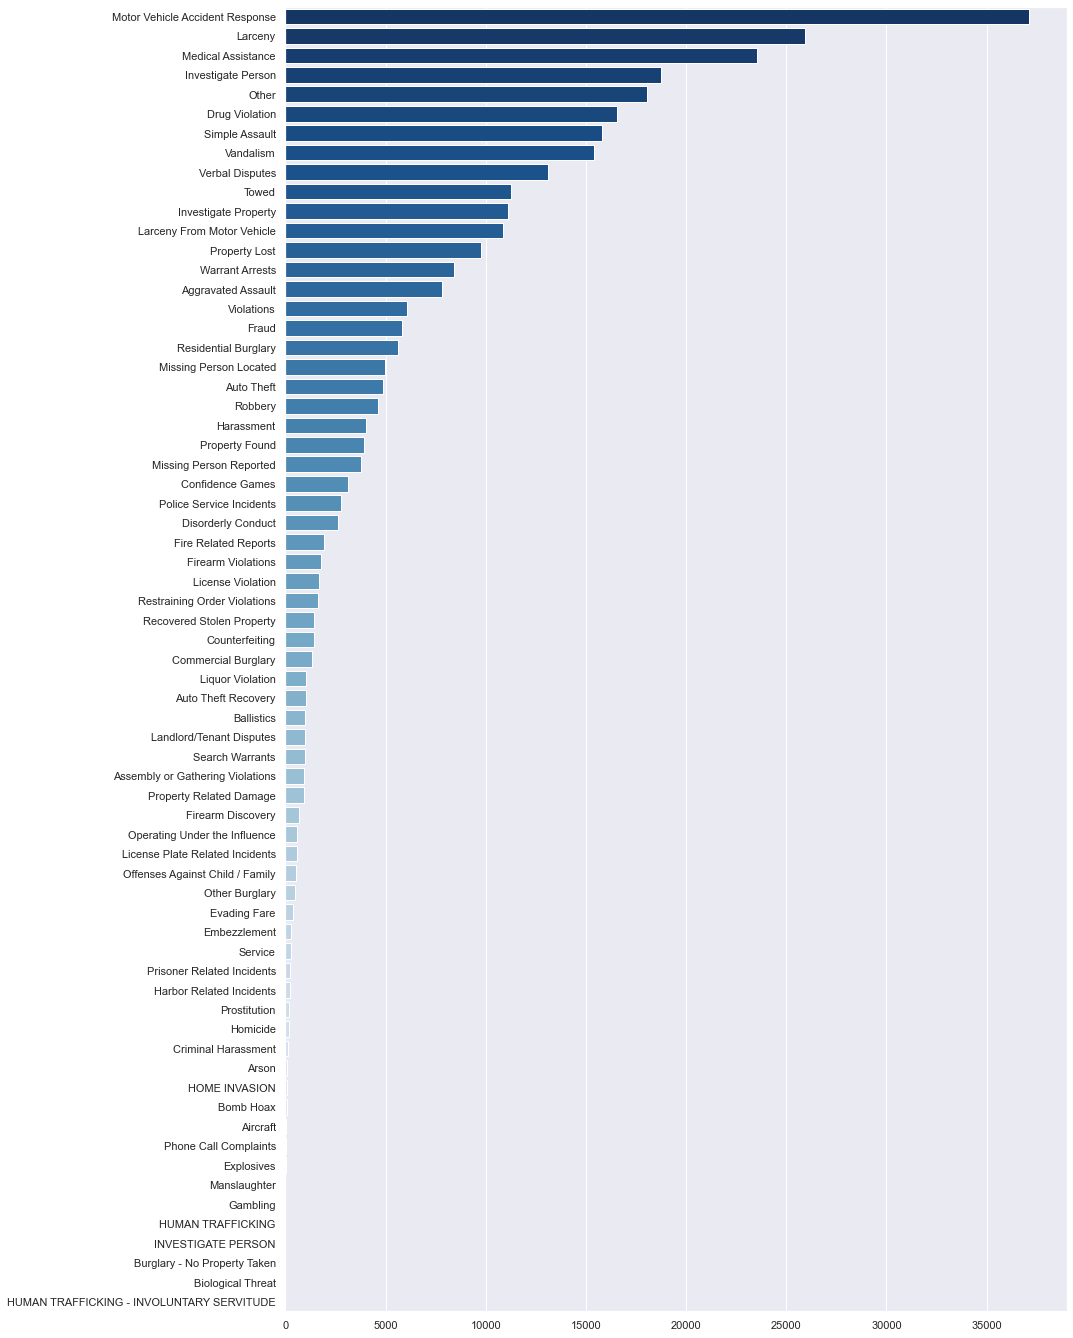

In [27]:
df = data['OFFENSE_CODE_GROUP'].value_counts()
plt.figure(figsize=(14,24))
sns.barplot(y=df.index, x=df.values, palette='Blues_r')
# plt.bar(df.index, height = df, )
# plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

Conclusion: we can observe that three most common crimes in Boston are Motor Vehicle Accident Response, Larceny and Medical Assistance

Further, we will take a closer look on most popular crimes in each district. For this analysis we will need to delete missing district values

In [28]:
data1 = data[data['DISTRICT'].notna()]

Visualisation of the most popular 15 crimes in each Boston district and for whole Boston

district_name: South Boston


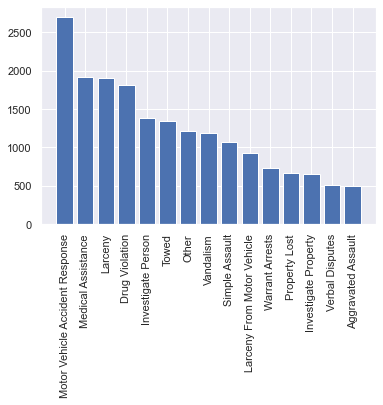

district_name: Hyde Park


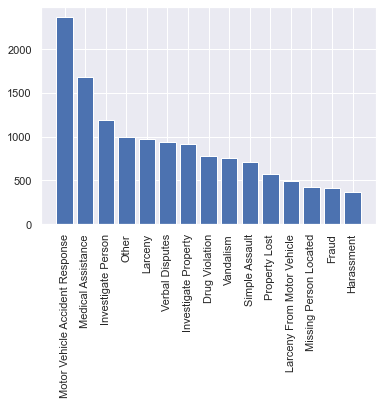

district_name: Brighton


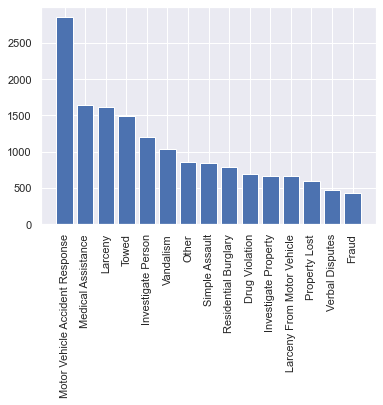

district_name: Dorchester


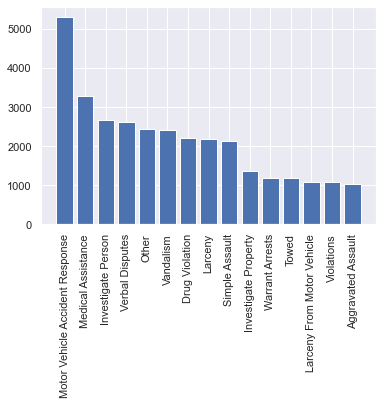

district_name: Charlestown


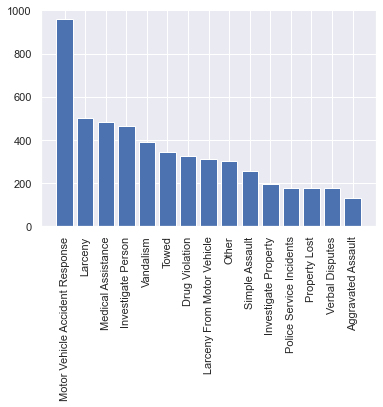

district_name: Mattapan


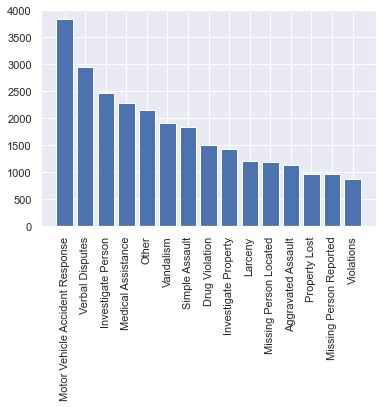

district_name: East Boston


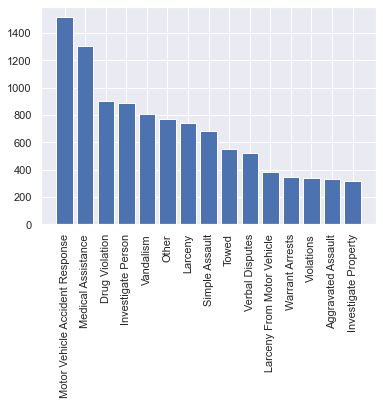

district_name: Downtown


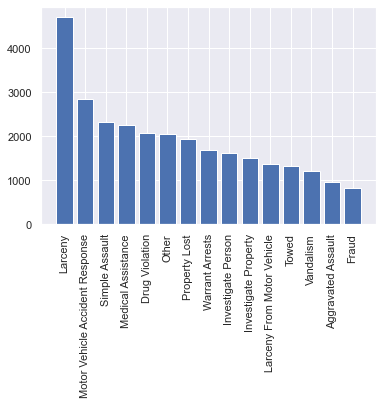

district_name: South End


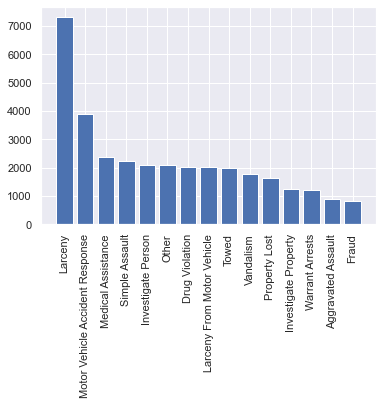

district_name: West Roxbury


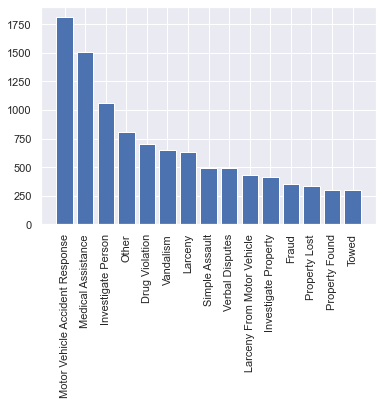

district_name: Jamaica Plain


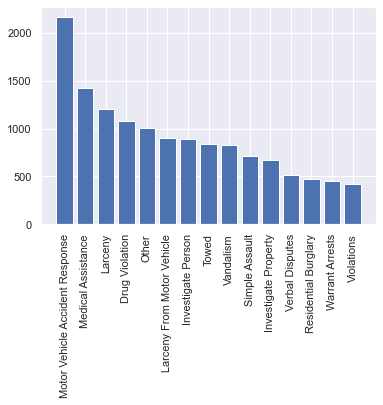

district_name: Roxbury


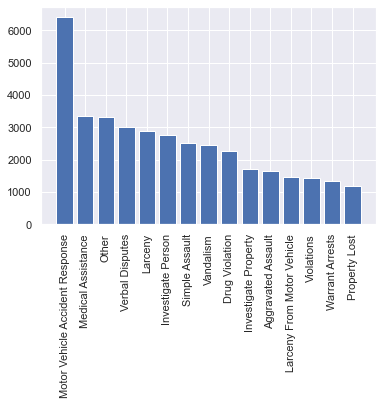

Overall


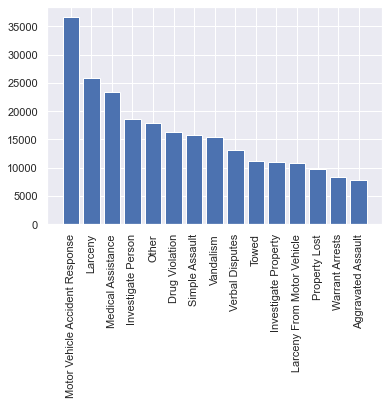

In [124]:
# Most common crimes by district
plot_crime_counts(data1, 'district_name', var_to_plot='OFFENSE_CODE_GROUP', k=15)

Conclusion: From the above plots we can see that each district has its own distribution of crimes e.g. Larceny is the most popular crime in South End, but in West Roxbury this crime type is just on the 7th place


In order to make this difference between district crimes distributions more visible let us visualize the difference in Larceny crimes in Downtown and Mattapan districts

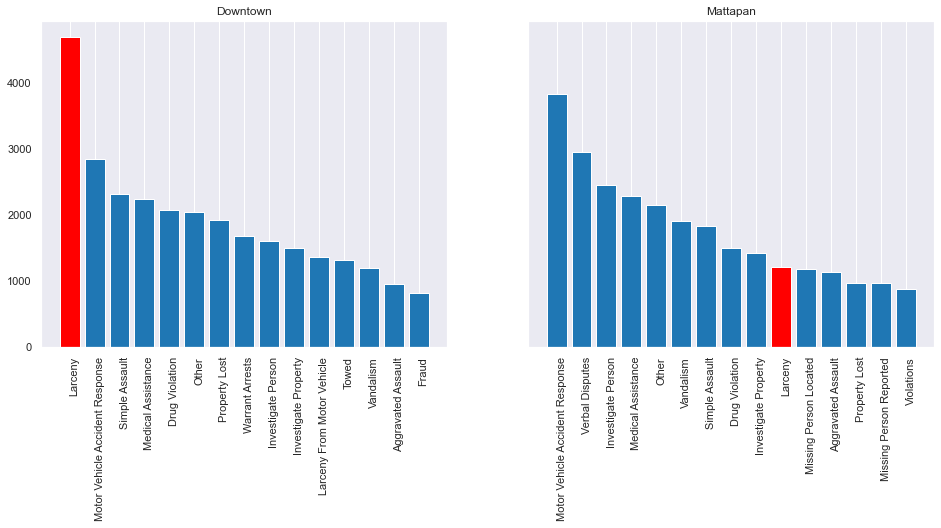

In [45]:
df1 = data1[data1.district_name=='Downtown']['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]
df2 = data1[data1.district_name=='Mattapan']['OFFENSE_CODE_GROUP'].value_counts().sort_values(ascending = False)[:15]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (16,6))

# c1 = ['blue' if i != 'Larceny' else 'red' for i in df1.index]
# c2 = ['blue' if i != 'Larceny' else 'red' for i in df2.index]

c1 = [u'#1f77b4' if i != 'Larceny' else 'red' for i in df1.index]
c2 = [u'#1f77b4' if i != 'Larceny' else 'red' for i in df2.index]

ax1.bar(df1.index, height = df1, color=c1)
ax1.set_title('Downtown')
ax1.grid(axis='y')
plt.setp(ax1.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")


ax2.bar(df2.index, height = df2, color=c2)
ax2.set_title('Mattapan')
ax2.grid(axis='y')
ax2.set_xticks(df2.index)
plt.setp(ax2.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
plt.show()

Conclusion: From the above plot we can see that distribution of 15 most common crimes can differ a lot between two districts. It means that each district has it's own crimes distribution. Some crimes popular in one district may not appear very often in another district e.g. Verbal Disputes is on the 2nd place in Mattapan, but in Downtown it doesn't appear to be popular crime. The reason for this differences might be that peaple living in Mattapan are more verbally agressive. On the other hand, in Downtown there might be some groups which are specialized in Larceny.

## Question 2. What is the most dangerous district in Boston?

In order to address this question let us take a look at number of crimes in each district

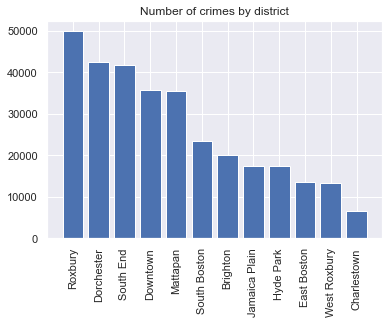

In [115]:
# no crimes by district

df = data.groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
plt.title('Number of crimes by district')
plt.bar(df.index, height = df)

plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

We can see that Roxbury has got the highest number of all crimes 

However, we might be interested in determining the numbers of crimes which are dangerous (by dangerous we mean crimes in which shooting took place)

## Crimes with shooting

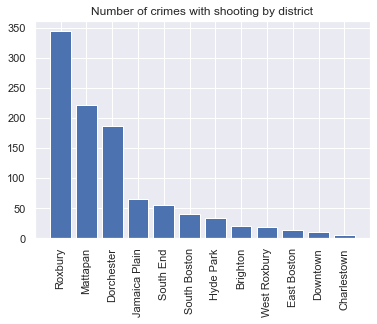

In [116]:
# number of crimes with shooting

df = data[data.SHOOTING ==1].groupby('district_name')['OFFENSE_CODE_GROUP'].count().sort_values(ascending = False)
plt.title('Number of crimes with shooting by district')
plt.bar(df.index, height = df)

plt.xticks(ticks=range(len(df)), labels=df.index, rotation=90)
plt.show()

Conclusion: We can observe small differences when comparing to the previous picture e.g. Downtown seems to not be a dangerous place in terms of crimes with shooting, but previously in was on the 4th place in terms of overall numbers of crimes.

In order to find an ansear to our question analitically we will provide hypothesis testing. Below, we will use z-test to find out which district is the most dangerous with statistical significance at the level of significance equal to 0.05.

In [113]:
# test the hypothesis that Roxbury is the most dangerous district in Boston
# construct column with all weekdays of crimes
districts = data[np.logical_and(data.SHOOTING ==1, data.DISTRICT.notna())].district_name

for dist in set(districts):
    if dist != 'Roxbury':
        rox_counts = districts == 'Roxbury'
        dist_counts = districts == dist
        z_score, pv = ztest(rox_counts, dist_counts, alternative = 'larger')
        print(f'testing Roxbury having more crimes than {dist}: \n z-score:{z_score}, p-value: {pv:.3f}')
        print(rox_counts.sum(), dist_counts.sum())
        if pv < 0.05/12:
            print(f'Roxbury has significantly larger number of crimes than {dist} \n')
        else:
            print('difference is not significant \n')

    

testing Roxbury having more crimes than South Boston: 
 z-score:18.534555370684167, p-value: 0.000
344 41
Roxbury has significantly larger number of crimes than South Boston 

testing Roxbury having more crimes than Hyde Park: 
 z-score:19.197280010454588, p-value: 0.000
344 34
Roxbury has significantly larger number of crimes than Hyde Park 

testing Roxbury having more crimes than Brighton: 
 z-score:20.595119538988435, p-value: 0.000
344 20
Roxbury has significantly larger number of crimes than Brighton 

testing Roxbury having more crimes than Dorchester: 
 z-score:8.047242093140982, p-value: 0.000
344 187
Roxbury has significantly larger number of crimes than Dorchester 

testing Roxbury having more crimes than Charlestown: 
 z-score:22.215949598199003, p-value: 0.000
344 5
Roxbury has significantly larger number of crimes than Charlestown 

testing Roxbury having more crimes than Mattapan: 
 z-score:6.142236428281583, p-value: 0.000
344 221
Roxbury has significantly larger number

Based on the above analysis we conclude that Roxbury is significantly the most dangerous district in Boston meaning that Roxbury has significantly higher number of crimes committed than any other district at the significance level 0.05.

Let us take a look at how the crime distribution in each district looked like in each year

YEAR: 2016


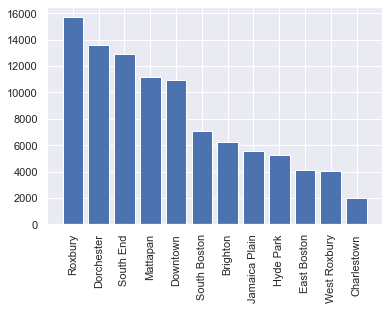

YEAR: 2017


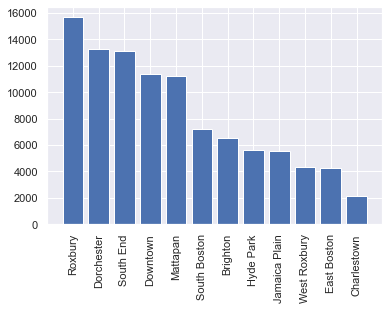

YEAR: 2018


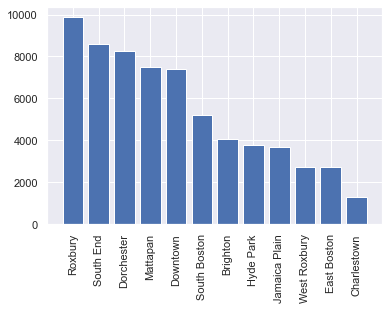

YEAR: 2015


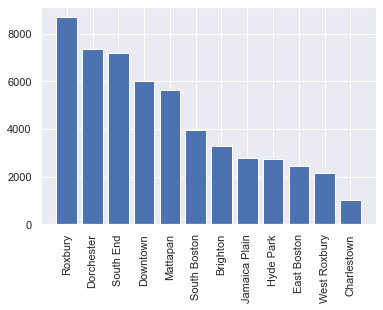

Overall


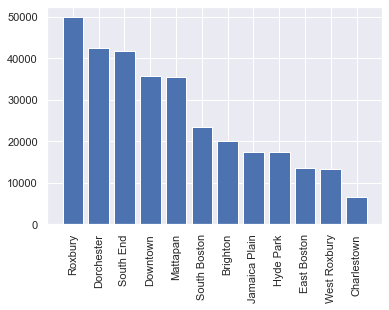

In [126]:
# by years
plot_crime_counts(data, 'YEAR', 'district_name')

Conclusion: From the above histograms we can conclude that the distribution of crimes by district didn't change a lot among years

YEAR: 2016


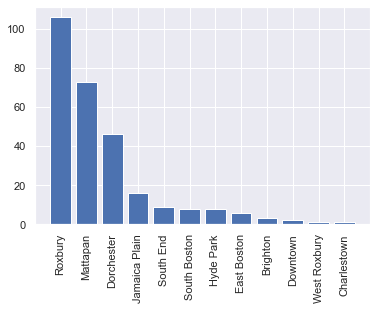

YEAR: 2017


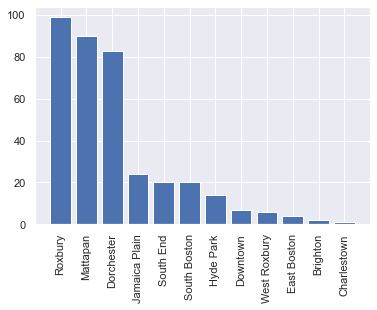

YEAR: 2018


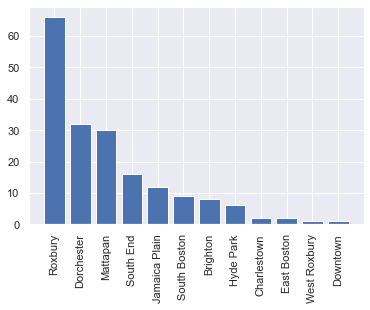

YEAR: 2015


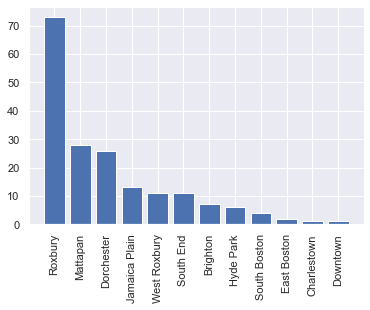

Overall


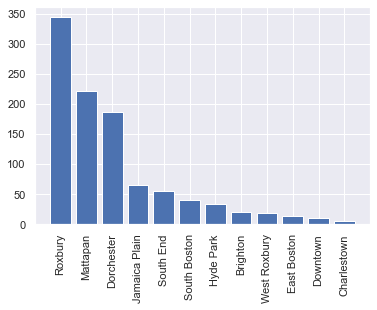

In [127]:
# number of shooting over years
df = data[data['SHOOTING']==1]
plot_crime_counts(df, 'YEAR', 'district_name')

Conclusion: Similar as previously, the distribution of crimes doesn't vary among different years. We can also observe from the above plots that the most dangerous district in Boston is Roxbury. This can be observed in each year as well as for all years together.

## Question 3. When most crimes are committed? (Which month, day of week, hour)

To address this question let us provide analysis and vizualisations separately for days of week, months and hours.

### Determine the most dangerous day of week with distinction on shooting and all crimes.

Let us take a look at the overall number of crimes by day of week

In [128]:
data.groupby('DAY_OF_WEEK')['SHOOTING'].count().sort_values()

DAY_OF_WEEK
Sunday       40313
Saturday     44818
Monday       45679
Tuesday      46383
Thursday     46656
Wednesday    46729
Friday       48495
Name: SHOOTING, dtype: int64

In [129]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = data['DAY_OF_WEEK'].map(mapping)

Now let us take al look at the number of crimes with shooting by day of week

In [130]:
data.groupby('DAY_OF_WEEK')['SHOOTING'].sum().sort_values()

DAY_OF_WEEK
Monday       114
Tuesday      114
Thursday     131
Wednesday    134
Friday       143
Sunday       155
Saturday     228
Name: SHOOTING, dtype: int64

In [131]:
data = data.iloc[key.argsort()]

### Crimes with shooting

2016
{'Monday': 26, 'Tuesday': 40, 'Wednesday': 21, 'Thursday': 44, 'Friday': 40, 'Saturday': 66, 'Sunday': 42}


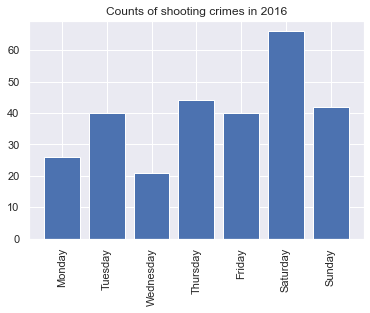

2017
{'Monday': 37, 'Tuesday': 45, 'Wednesday': 49, 'Thursday': 39, 'Friday': 54, 'Saturday': 73, 'Sunday': 73}


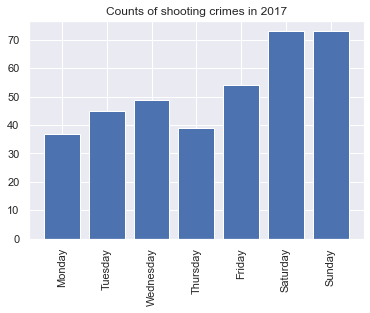

2018
{'Monday': 27, 'Tuesday': 18, 'Wednesday': 32, 'Thursday': 18, 'Friday': 28, 'Saturday': 41, 'Sunday': 21}


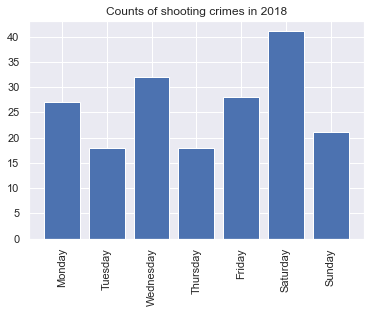

2015
{'Monday': 24, 'Tuesday': 11, 'Wednesday': 32, 'Thursday': 30, 'Friday': 21, 'Saturday': 48, 'Sunday': 19}


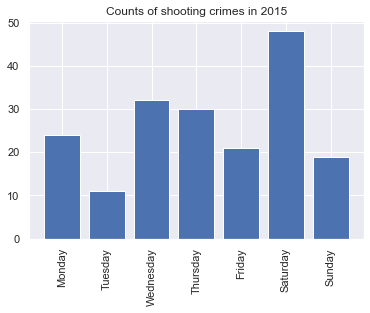

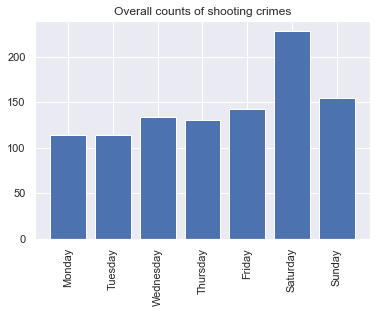

In [133]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}

for year in set(data.YEAR):
    week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
    print(year)
    df = data[np.logical_and(data['YEAR']==year, data['SHOOTING']==1)].groupby('DAY_OF_WEEK')['SHOOTING'].count().reset_index()
    df.columns = ['DAY_OF_WEEK', 'VALUE']
    for day in week_counter.keys():
        week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    print(week_counter)
    plt.bar(week_counter.keys(), week_counter.values())
    plt.title(f'Counts of shooting crimes in {year}')
#     plt.grid(axis='y')
    plt.xticks(ticks=range(len(week_counter.keys())), labels=week_counter.keys(), rotation=90)
    plt.show()
week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
df = data.groupby('DAY_OF_WEEK')['SHOOTING'].sum().reset_index()
df.columns = ['DAY_OF_WEEK', 'VALUE']
for day in week_counter.keys():
    week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    
plt.bar(week_counter.keys(), week_counter.values())
plt.title(f'Overall counts of shooting crimes')
plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
# plt.grid(axis='y')
plt.show()

Conclusion: We can see that Saturday is a good candidate to be the most dangerous day of week. Further we will provide statisticall evidence to check whether it is true.

Let's provide hypothesis tests in order to find the most dangerous day of week in terms of crimes with shooting. We use z-test in order to check whether any day has significantly higher number of crimes than any other day of week. Here we apply Bonferroni correction as for each day of week we provide 7 comparissons.

In [57]:
# test the hypothesis that during Saturday the number of crimes with shooting is bigger than in any other days
# construct column with all weekdays of crimes
week_days = data[data.SHOOTING == 1].DAY_OF_WEEK

for day in week_counter.keys():
    for another_day in week_counter.keys():
        if day != another_day:
            day_counts = week_days == day
            another_day_counts = week_days == another_day
            z_score, pv = ztest(day_counts, another_day_counts, alternative = 'larger')
            print(f'testing {day} having more crimes than {another_day}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(day_counts.sum(), another_day_counts.sum())
            if pv < 0.05/7:
                print(f'{day} has significantly larger number of crimes than {another_day} \n')
            else:
                print('difference is not significant \n')

    

testing Monday having more crimes than Tuesday: 
 z-score:0.0, p-value: 0.500
114 114
difference is not significant 

testing Monday having more crimes than Wednesday: 
 z-score:-1.355071708884565, p-value: 0.912
114 134
difference is not significant 

testing Monday having more crimes than Thursday: 
 z-score:-1.1577306383138037, p-value: 0.877
114 131
difference is not significant 

testing Monday having more crimes than Friday: 
 z-score:-1.935921362892027, p-value: 0.974
114 143
difference is not significant 

testing Monday having more crimes than Saturday: 
 z-score:-6.831065066275271, p-value: 1.000
114 228
difference is not significant 

testing Monday having more crimes than Sunday: 
 z-score:-2.6865883514090934, p-value: 0.996
114 155
difference is not significant 

testing Tuesday having more crimes than Monday: 
 z-score:0.0, p-value: 0.500
114 114
difference is not significant 

testing Tuesday having more crimes than Wednesday: 
 z-score:-1.3550717088845652, p-value: 0.91

Conclusion: We can see from the above result that on Saturday the number of shooting crimes is significantly higher
than in any other day of week, thus we conclude that Saturday is the most dangerous day in the week in terms of crimes overall. 

### without shooting

Let's visualize number of crimes by day of week for each year and for all years at once.

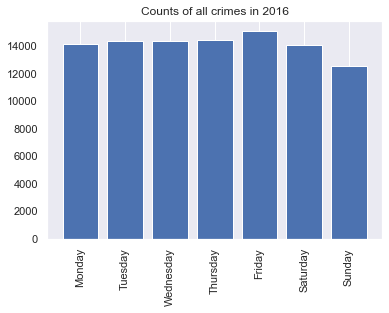

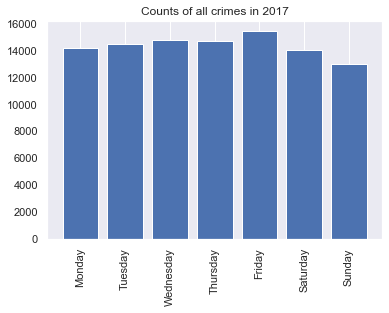

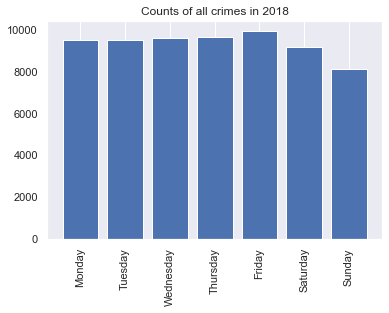

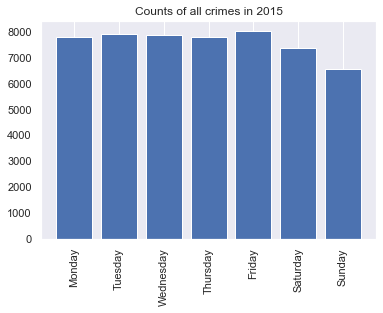

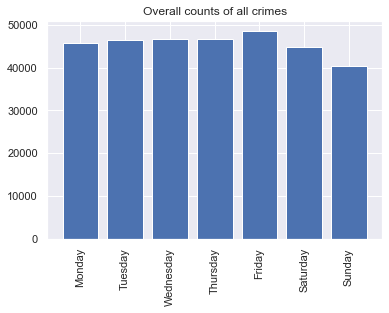

In [134]:
# crimes without shooting
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# mapping = {day: i for i, day in enumerate(weekdays)}

for year in set(data.YEAR):
    week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
    df = data[data['YEAR']==year].groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count().reset_index()
    df.columns = ['DAY_OF_WEEK', 'VALUE']
    for day in week_counter.keys():
        week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    plt.bar(week_counter.keys(), week_counter.values())
    plt.title(f'Counts of all crimes in {year}')
    plt.grid(axis='y')
    plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
    plt.show()
week_counter = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
df = data.groupby('DAY_OF_WEEK')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['DAY_OF_WEEK', 'VALUE']
for day in week_counter.keys():
    week_counter[day] = df[df.DAY_OF_WEEK == day]['VALUE'].values[0]
    
plt.bar(week_counter.keys(), week_counter.values())
plt.title(f'Overall counts of all crimes')
plt.xticks(ticks=range(len(df)), labels=week_counter.keys(), rotation=90)
plt.show()

In terms of crimes overall Friday is our candidate to be the most dangerous day of week. However, the above plots do not show that there is significant difference between Friday and other days of week.

Let's test the hypothesis tests for each day of week to check whether a given day has significantly more crimes than any other day. Here we apply Benferroni correction term because we provide multiple comparissons.

In [135]:
# construct column with all weekdays of crimes
week_days = data.DAY_OF_WEEK

for day in week_counter.keys():
    for another_day in week_counter.keys():
        if day != another_day:
            day_counts = week_days == day
            another_day_counts = week_days == another_day
            z_score, pv = ztest(day_counts, another_day_counts, alternative = 'larger')
            print(f'testing {day} having more crimes than {another_day}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(day_counts.sum(), another_day_counts.sum())
            if pv < 0.05/7:
                print(f'{day} has significantly larger number of crimes than {another_day} \n')
            else:
                print('difference is not significant \n')

    

testing Monday having more crimes than Tuesday: 
 z-score:-2.50821185499817, p-value: 0.994
45679 46383
difference is not significant 

testing Monday having more crimes than Wednesday: 
 z-score:-3.7351367656118164, p-value: 1.000
45679 46729
difference is not significant 

testing Monday having more crimes than Thursday: 
 z-score:-3.4765918112772294, p-value: 1.000
45679 46656
difference is not significant 

testing Monday having more crimes than Friday: 
 z-score:-9.939666890229194, p-value: 1.000
45679 48495
difference is not significant 

testing Monday having more crimes than Saturday: 
 z-score:3.0895661905533203, p-value: 0.001
45679 44818
Monday has significantly larger number of crimes than Saturday 

testing Monday having more crimes than Sunday: 
 z-score:19.67807459008959, p-value: 0.000
45679 40313
Monday has significantly larger number of crimes than Sunday 

testing Tuesday having more crimes than Monday: 
 z-score:2.50821185499817, p-value: 0.006
46383 45679
Tuesday h

Conclusion: from the above results we can see that Friday has significantly higher number of crimes than any other day in the week. Thus we can say that Friday is the most dangerous day of week (In terms of all types of crimes).

### Determine the most dangerous month

Let's take a look at the overall number of crimes by month

In [137]:
# number of crimes observed in each month
data['MONTH'].value_counts().sort_values()

2     21653
12    23477
1     23610
11    23675
4     24086
3     24146
10    25737
5     26199
9     26543
6     30568
7     34556
8     34823
Name: MONTH, dtype: int64

2016


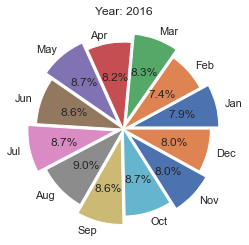

2017


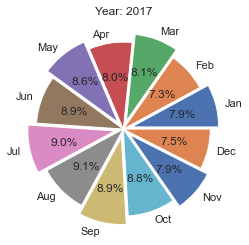

2018


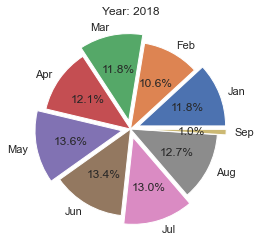

2015


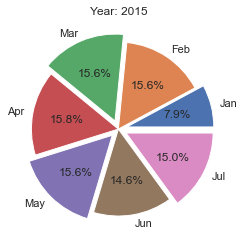

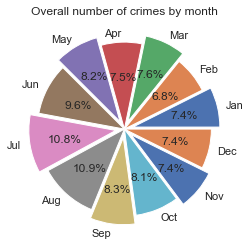

In [138]:
# Visualize the frequency of crimes committed in each month
labels = ['Jan','Feb','Mar','Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
explode = [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0]

for year in set(data.YEAR):
    print(year)
    df = data[data['YEAR']==year].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
    plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
    plt.title(f'Year: {year}')
    plt.show()
df = data.groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
plt.title(f'Overall number of crimes by month')
plt.show()

Conclusions: When looking at frequency of crimes by month for each year separately, we can observe that there isn't any month with the highest numbers in each year. When we look at the numbers overall then August has the biggest number of crimes reported. In oreder to check whether August is significantly more dangerous month than other months we will provide hypothesis testing analysis.

Note: In Year 2015 some months were not reported, for further analysis we will not take into account this year

In [139]:
data2 = data[data.YEAR != 2015]

Let's count the frequency of crimes by month and save results in a dictionary

In [140]:
month_counter = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'June':0, 'Jul':0, 'Aug': 0, 'Oct':0, 'Nov':0, 'Dec':0}
df = data2.groupby('MONTH')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['MONTH', 'VALUE']

for i, month in enumerate(month_counter.keys()):
    month_counter[month] = df[df.MONTH == i+1]['VALUE'].values[0]
    

Let us provide hypothesis testing procedure in order to determine the most dangerous month. Here we will provide z-test in order to check whether a given month is significantly more dangerous than all other months. We apply the Bonferroni correction term, because each month is compared to 11 months.

In [141]:
# Checking if any month has significanty more crimes than other

months = data2.MONTH

for i1, m1 in enumerate(month_counter.keys()):
    for i2, m2 in enumerate(month_counter.keys()):
        if m1 != m2:
            month_counts = months == i1+1
            another_month_counts = months == i2+1
            
            z_score, pv = ztest(month_counts, another_month_counts, alternative = 'larger')
            print(f'testing {m1} having more crimes than {m2}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(month_counts.sum(), another_month_counts.sum())
            if pv < 0.05/11:
                print(f'{m1} has significantly larger number of crimes than {m2} \n')
            else:
                print('difference is not significant \n')

    

testing Jan having more crimes than Feb: 
 z-score:9.618087406289247, p-value: 0.000
23610 21653
Jan has significantly larger number of crimes than Feb 

testing Jan having more crimes than Mar: 
 z-score:-2.570998274906294, p-value: 0.995
23610 24146
difference is not significant 

testing Jan having more crimes than Apr: 
 z-score:-2.284490904561141, p-value: 0.989
23610 24086
difference is not significant 

testing Jan having more crimes than May: 
 z-score:-12.187394636203974, p-value: 1.000
23610 26199
difference is not significant 

testing Jan having more crimes than June: 
 z-score:-13.004751231146445, p-value: 1.000
23610 26377
difference is not significant 

testing Jan having more crimes than Jul: 
 z-score:-12.339117310785673, p-value: 1.000
23610 26232
difference is not significant 

testing Jan having more crimes than Aug: 
 z-score:-13.481146897635115, p-value: 1.000
23610 26481
difference is not significant 

testing Jan having more crimes than Oct: 
 z-score:27.9686472

26481 24086
Aug has significantly larger number of crimes than Apr 

testing Aug having more crimes than May: 
 z-score:1.2944862175929592, p-value: 0.098
26481 26199
difference is not significant 

testing Aug having more crimes than June: 
 z-score:0.47668265608023347, p-value: 0.317
26481 26377
difference is not significant 

testing Aug having more crimes than Jul: 
 z-score:1.142684943842436, p-value: 0.127
26481 26232
difference is not significant 

testing Aug having more crimes than Oct: 
 z-score:41.38217611969609, p-value: 0.000
26481 18129
Aug has significantly larger number of crimes than Oct 

testing Aug having more crimes than Nov: 
 z-score:45.18808074251677, p-value: 0.000
26481 17429
Aug has significantly larger number of crimes than Nov 

testing Aug having more crimes than Dec: 
 z-score:53.96832610173686, p-value: 0.000
26481 15857
Aug has significantly larger number of crimes than Dec 

testing Oct having more crimes than Jan: 
 z-score:-27.968647295630035, p-valu

Conclusion: From the above analysis we cannot find a month which has significantly bigger number of crimes than all other months.

### Crimes with shooting

2016


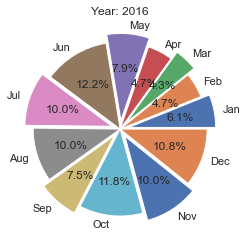

2017


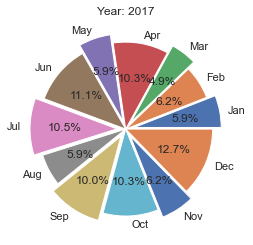

2018


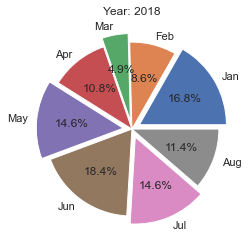

2015


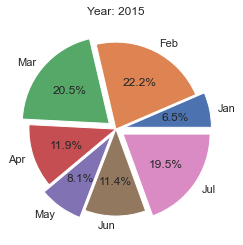

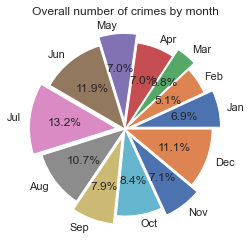

In [142]:
# By MONTH with shooting
labels = ['Jan','Feb','Mar','Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
explode = [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0]

for year in set(data.YEAR):
    print(year)
    df = data[np.logical_and(data['YEAR']==year, data['SHOOTING']==1)].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
    plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
    plt.title(f'Year: {year}')
    plt.show()
df = data[data['SHOOTING'] ==1].groupby('MONTH')['OFFENSE_CODE_GROUP'].count()
#     print(df)
plt.pie(df, labels = labels[:len(df)], autopct = '%1.1f%%',explode = explode[:len(df)])
plt.title(f'Overall number of crimes by month')
plt.show()

Conclusion: Based on the above visualization we can see that in each year there was different month with the highest number of crimes with shooting. Overall it seems that July is most dangerous. However we will need to provide hypothesis testing to check whether this month has significantly higher number of crimes than any other month.

In [143]:
data2 = data[data.SHOOTING == 1][data.YEAR != 2015]
month_counter = {'Jan':0, 'Feb':0, 'Mar':0, 'Apr':0, 'May':0, 'June':0, 'Jul':0, 'Aug': 0, 'Oct':0, 'Nov':0, 'Dec':0}
df = data2.groupby('MONTH')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['MONTH', 'VALUE']

for i, month in enumerate(month_counter.keys()):
    month_counter[month] = df[df.MONTH == i+1]['VALUE'].values[0]
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Let us provide hypothesis testing procedure in order to determine the most dangerous crime. Here we will provide z-test in order to check whether a given month is significantly more dangerous than all other months. Here we apply the Bonferroni correction term, because each month is compared to 11 months.

In [144]:
# Checking if any month has significanty more shooting crimes than other

months = data2[data2.SHOOTING ==1].MONTH

for i1, m1 in enumerate(month_counter.keys()):
    for i2, m2 in enumerate(month_counter.keys()):
        if m1 != m2:
            month_counts = months == i1+1
            another_month_counts = months == i2+1
            z_score, pv = ztest(month_counts, another_month_counts, alternative = 'larger')
            print(f'testing {m1} having more crimes than {m2}: \n z-score:{z_score}, p-value: {pv:.3f}')
            print(month_counts.sum(), another_month_counts.sum())
            if pv < 0.05/11:
                print(f'{m1} has significantly larger number of crimes than {m2} \n')
            else:
                print('difference is not significant \n')

    

testing Jan having more crimes than Feb: 
 z-score:1.693162660838322, p-value: 0.045
70 52
difference is not significant 

testing Jan having more crimes than Mar: 
 z-score:3.0781826808872554, p-value: 0.001
70 39
Jan has significantly larger number of crimes than Mar 

testing Jan having more crimes than Apr: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not significant 

testing Jan having more crimes than May: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not significant 

testing Jan having more crimes than June: 
 z-score:-3.092224198891097, p-value: 0.999
70 109
difference is not significant 

testing Jan having more crimes than Jul: 
 z-score:-1.974742991623185, p-value: 0.976
70 94
difference is not significant 

testing Jan having more crimes than Aug: 
 z-score:-0.08796490383028648, p-value: 0.535
70 71
difference is not significant 

testing Jan having more crimes than Oct: 
 z-score:1.1036010057626795, p-value: 0.135
70 58
differen

Conclusion: based on the above output we cannot find a month which has significantly higher number of crimes with shooting than any other month. Hence we cannot show the most dangerous month!

### Determine the most dangerous hour

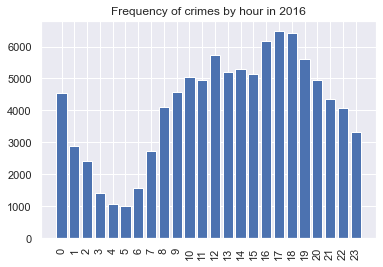

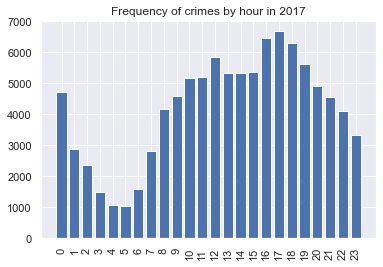

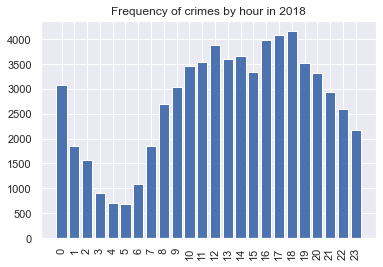

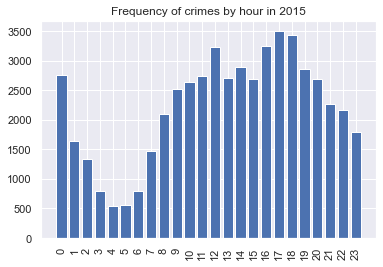

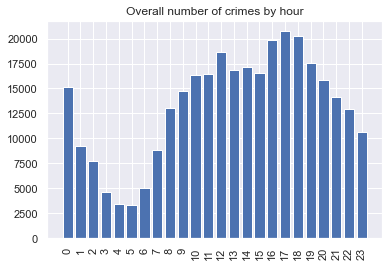

In [145]:
# Overall frequency of crimes by hour of day

# for each year compute the number of crimes by hour and create barplot with frequencies
for year in set(data.YEAR):
    hour_counter = {i:0 for i in range(24)}
    df = data[data['YEAR']==year].groupby('HOUR')['OFFENSE_CODE_GROUP'].count().reset_index()
    df.columns = ['HOUR', 'VALUE']
    for hour in hour_counter.keys():
        hour_counter[hour] = df[df.HOUR == hour]['VALUE'].values[0]
    plt.bar(hour_counter.keys(), hour_counter.values())
    plt.title(f'Frequency of crimes by hour in {year}')
    plt.xticks(ticks=range(len(hour_counter.values())), labels=hour_counter.keys(), rotation=90)
    plt.show()
    
# compute number of crimes by hour for the full period of time and produce barplot with frequencies
df = data.groupby('HOUR')['OFFENSE_CODE_GROUP'].count().reset_index()
df.columns = ['HOUR', 'VALUE']
for hour in hour_counter.keys():
    hour_counter[hour] = df[df.HOUR == hour]['VALUE'].values[0]
plt.bar(hour_counter.keys(), hour_counter.values())
plt.title(f'Overall number of crimes by hour')
plt.xticks(ticks=range(len(hour_counter.values())), labels=hour_counter.keys(), rotation=90)
plt.show()

From the above visualizations we can see that the distribution of crimes by hour remains similar during all years. Most crimes occur during the day especially between 4 p.m.-7p.m. We can observe high peaks in the midnight and 12 o-clock. This conclusions are visible when looking at the frequencies for all years and for each year separately.

Crimes with shooting

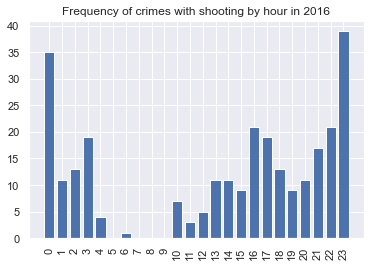

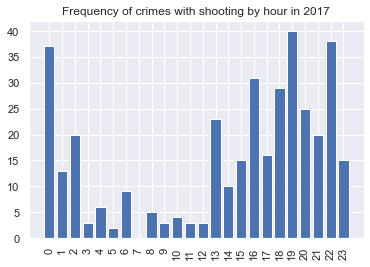

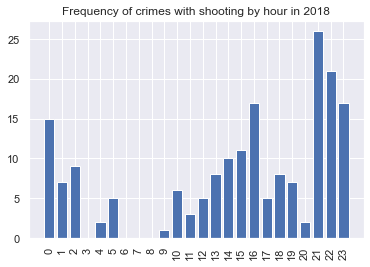

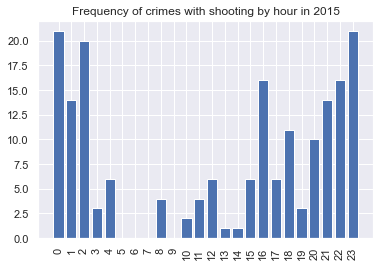

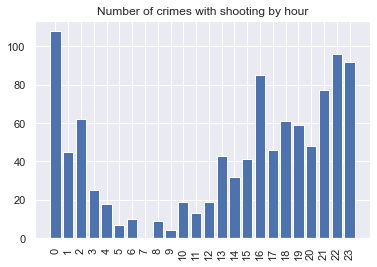

In [146]:
# SHOOTING frequency of crimes by hour of day

for year in set(data.YEAR):
    hour_counter = {i:0 for i in range(24)}
    df = data[data['YEAR']==year].groupby('HOUR')['SHOOTING'].sum().reset_index()
    df.columns = ['HOUR', 'VALUE']
    for hour in hour_counter.keys():
        hour_counter[hour] = df[df.HOUR == hour]['VALUE'].values[0]
    plt.bar(hour_counter.keys(), hour_counter.values())
    plt.title(f'Frequency of crimes with shooting by hour in {year}')
    plt.xticks(ticks=range(len(hour_counter.values())), labels=hour_counter.keys(), rotation=90)
    plt.show()

df = data.groupby('HOUR')['SHOOTING'].sum().reset_index()
df.columns = ['HOUR', 'VALUE']
for hour in hour_counter.keys():
    hour_counter[hour] = df[df.HOUR == hour]['VALUE'].values[0]
plt.bar(hour_counter.keys(), hour_counter.values())
plt.title(f'Number of crimes with shooting by hour')
plt.xticks(ticks=range(len(hour_counter.values())), labels=hour_counter.keys(), rotation=90)
plt.show()

Conclusion: We can see that crimes with shooting occure more often during late hours 9 p.m. - 12 p.m. There is also an unexpected peak at 4 p.m. This conclusions are visible when looking at the frequencies for all years and for each year separately.